In [65]:
import pandas as pd
from gensim.models import Word2Vec
from termcolor import colored
import warnings
import re
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
warnings.filterwarnings("ignore")
%matplotlib inline

In [66]:
#Using the Google News Model
#not pushed because it is too big but can be found here: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
model = Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
query_number = 0

In [67]:
#I will be using the first folder as my data
queries_file = open("data/user_studies/all.txt", "r")
lines = queries_file.readlines()
lines = [l.strip() for l in lines]
# remove all strings with length < 3
queries = []
for i in lines:
    if not len(i)<3:
        queries.append(i)

In [68]:
#helper functions
def get_query_vector(q):
    """returns the vector for sentence"""
    #remove all punctuation from query
    q = re.sub(r'[^\w\s]','',q)
    #split by word
    q = q.split(" ")
    # remove extra spaces
    q = [i.strip() for i in q]
    query_vec = np.zeros(300)
    #adds the vectors of all individual words to get
    for w in q:
        try:
            query_vec+=model[w]
        except KeyError:
            pass
    return query_vec

#Get results based on query number
def get_results(q_num):
    filename = "./data/user_studies/results_"+str(q_num)+".txt"
    f = open(filename, "r")
    lst = f.readlines()
    lst = [i.split("--") for i in lst]
    lst = list(zip(*lst))
    scores = [float(i.strip()) for i in lst[0]]
    results = [i.strip() for i in lst[1]]
    return scores, results

#Underlines words
def underline_word(word):
    return colored(word, "yellow")

def similarity(vec1, vec2):
    return cosine_similarity(vec1, vec2)[0][0]

def max_similarity_word(q_vec, result):
    max_word = ''
    max_similarity = 0
    #remove punctuation from result
    result = re.sub(r'[^\w\s]','',result)
    result = result.split(" ")
    result = [i.strip() for i in result]
    for word in result:
        try:
            s = similarity(q_vec, model[word])
            if s > max_similarity:
                max_similarity = s
                max_word = word
        except KeyError:
            pass
    return max_word

In [69]:
query = queries[query_number]
scores, results = get_results(query_number)
q_vec = get_query_vector(query)

In [70]:
query

'neighbor'

**Visualization 1:** Finding the word that is most similar in a sentence

In [71]:
for score,sentence in zip(scores, results):
    similar_word = max_similarity_word(q_vec, sentence)
    my_regex = r"\b" + re.escape(similar_word) + r"\b"
    sentence = re.sub(my_regex, underline_word(similar_word), sentence)
    print(str(score)+"--"+sentence)

0.847--played outside with elijah , neighbor dog , neighbor sheep , and neighbor kids .
0.696--that includes a neighbor , a friend , a mother , father , sibling , spouse , lover .
0.696--if your friend , girlfriend , roommate , sister , mom , cousin , aunt , neighbor , aquaintance , etc .
0.694--stepdad : : : is holding the puppy , when the neighbor comes out : : neighbor : you !
0.687--he was a good father , husband , teacher , neighbor , and friend .
0.686--he was a neighbor , a collegue , and a very close family friend .
0.684--: pm go to neighbor s house to teach neighbor s niece ... call center articulation .
0.684--i was shuffled from neighbor to neighbor to my aunt and uncle s house and back again .
0.682--my mom , our next door neighbor , and our next door neighbor s wife .
0.679--she was the former nextdoor neighbor of a mother of a friend of a friend sort of person .
0.678--give a hug to a friend , a neighbor , a teacher , a stranger .
0.678--and last but not least ... i thin

**Visualization 2:** How much of the space have I explored?

In [72]:
#Idea: Use dimensionality reduction and plot all the results on a 3d plot
from sklearn.decomposition import PCA
import pandas as pd
pca = PCA(n_components=3)

In [73]:
df = pd.DataFrame(columns=np.arange(0,300))
for i in range(len(results)):
    df.loc[i] = get_query_vector(results[i])
mat = df.as_matrix()
data = pca.fit_transform(mat)

In [74]:
#Query 2
query_2 = queries[1]
scores, results = get_results(1)
df2 = pd.DataFrame(columns=np.arange(0,300))
for i in range(len(results)):
    df2.loc[i] = get_query_vector(results[i])
mat2 = df2.as_matrix()
data2 = pca.fit_transform(mat2)

In [75]:
#Query 3
query_3 = queries[2]
scores, results = get_results(2)
df3 = pd.DataFrame(columns=np.arange(0,300))
for i in range(len(results)):
    df3.loc[i] = get_query_vector(results[i])
mat3 = df3.as_matrix()
data3 = pca.fit_transform(mat3)

Query 1:  neighbor
Query 2:  neighbor in my building
Query 3:  next door neighbor


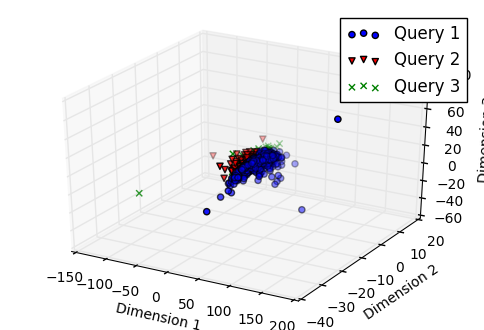

In [76]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
print("Query 1: ", query)
print("Query 2: ", query_2)
print("Query 3: ", query_3)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
scatter1 = ax.scatter(data[:,0], data[:,1], data[:,2])
scatter2 = ax.scatter(data2[:,0], data2[:,1], data2[:,2], c='red', marker='v')
scatter3 = ax.scatter(data3[:,0], data3[:,1], data3[:,2], c='green', marker ='x')
ax.legend([scatter1, scatter2, scatter3], ['Query 1', 'Query 2', 'Query 3'], loc = 'best')

**Visualization 3:** Quantifyng sentiment based on query data

In [77]:
#May have to install with conda install -c sloria textblob from anaconda
from textblob import TextBlob
score = []
for r in results:
    score.append(TextBlob(r).polarity)

In [78]:
df = pd.DataFrame(list(zip(scores, results, score)), columns=['similarity_score', 'sentence', 'sentiment_intensity'])

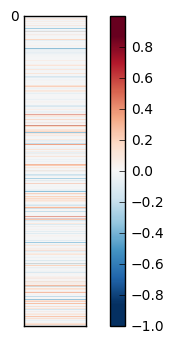

In [79]:
from numpy import outer
lst = np.array(df['similarity_score'])
labels = [i[0] for i in np.split(lst, 5)]
a=outer(df['sentiment_intensity'],np.ones(200))
pcm = plt.get_cmap('RdBu_r')
plt.imshow(a,cmap=pcm, vmin=-np.max(df['similarity_score']))
plt.colorbar(boundaries=np.arange(-1,1,0.0001))
plt.yticks([0])
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)

## Plotly 

In [80]:
import plotly.plotly as py
import plotly.graph_objs as go
import pandas as pd
import warnings
import re
warnings.filterwarnings("ignore")

In [81]:
#get the data
query1 = "reminiscence trigger trigger"
query2 = "neighbors"
query3 = "happy times"
query4 = "I redesigned my lifestyle to lose weight"

In [82]:
query_1_results = pd.read_table("data/labeled_data_1/results_1.txt", sep="--", names=["similarity_score", "sentence","sentiment","url"])
query_2_results = pd.read_table("data/labeled_data_1/results_2.txt", sep="--", names=["similarity_score", "sentence","sentiment","url"])
query_3_results = pd.read_table("data/labeled_data_1/results_3.txt", sep="--", names=["similarity_score", "sentence","sentiment","url"])

In [83]:
query_1_results.head()

,similarity_score,sentence,sentiment,url
0,0.661,her neighbor .,indifferent,http://nerfcake.livejournal.com/4475.html
1,0.590,family friends : parents ?,discontent,http://my-mercy.livejournal.com/10762.html
2,0.583,over at neighbor s house .,hungry,http://ninjapope.livejournal.com/5925.html
3,0.573,friends and family .,blah,http://mynamesnotlaura.livejournal.com/68441....
4,0.565,"friends , family members , relatives , are wa...",blank,http://amethyst-realm.livejournal.com/50763.html


In [84]:
#work with just the 1st result - extract username
f = lambda x: re.match('.*?\.',x[8:]).group()[:-1]
query_1_results['username'] = query_1_results.url.apply(f)
g = lambda x: re.search("com/(.*?).html", x).group(1)
query_1_results['post_id'] = query_1_results.url.apply(g)
query_1_results.head()

,similarity_score,sentence,sentiment,url,username,post_id
0,0.661,her neighbor .,indifferent,http://nerfcake.livejournal.com/4475.html,nerfcake,4475
1,0.590,family friends : parents ?,discontent,http://my-mercy.livejournal.com/10762.html,my-mercy,10762
2,0.583,over at neighbor s house .,hungry,http://ninjapope.livejournal.com/5925.html,ninjapope,5925
3,0.573,friends and family .,blah,http://mynamesnotlaura.livejournal.com/68441....,mynamesnotlaura,68441
4,0.565,"friends , family members , relatives , are wa...",blank,http://amethyst-realm.livejournal.com/50763.html,amethyst-realm,50763


In [85]:
query_1_results['vector'] = query_1_results.sentence.apply(lambda x: pca.fit_transform(get_query_vector(x)))
query_1_results.head()

,similarity_score,sentence,sentiment,url,username,post_id,vector
0,0.661,her neighbor .,indifferent,http://nerfcake.livejournal.com/4475.html,nerfcake,4475,[[0.0]]
1,0.590,family friends : parents ?,discontent,http://my-mercy.livejournal.com/10762.html,my-mercy,10762,[[0.0]]
2,0.583,over at neighbor s house .,hungry,http://ninjapope.livejournal.com/5925.html,ninjapope,5925,[[0.0]]
3,0.573,friends and family .,blah,http://mynamesnotlaura.livejournal.com/68441....,mynamesnotlaura,68441,[[0.0]]
4,0.565,"friends , family members , relatives , are wa...",blank,http://amethyst-realm.livejournal.com/50763.html,amethyst-realm,50763,[[0.0]]


## Prototype 1

In [86]:
df1 = pd.DataFrame(np.zeros([len(query_1_results.index), 300]))
for i in range(len(query_1_results.index)):
    df1.iloc[i] = get_query_vector(query_1_results.iloc[i, 1])

In [87]:
mat1 = df1.as_matrix()
data1 = pca.fit_transform(mat1)
x1 = data1[:, 0]
y1 = data1[:, 1]
z1 = data1[:, 2]

In [100]:
df2 = pd.DataFrame(np.zeros([len(query_2_results.index), 300]))
for i in range(len(query_2_results.index)):
    df2.iloc[i] = get_query_vector(query_2_results.iloc[i, 1])
mat2 = df2.as_matrix()
data2 = pca.fit_transform(mat2)
x2 = data2[:, 0]
y2 = data2[:, 1]
z2 = data2[:, 2]

In [101]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np
py.sign_in('oikobill', 'WSVy5LKYzG8IsYY8YNhA')

trace0 = go.Scatter3d(
    x=x1,
    y=y1,
    z=z1,
    mode='markers',
    marker=dict(
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
    size=5
    ), text= [i[:60]+"..." for i in query_1_results.sentence], hoverinfo='text', name=query1
)
trace1 = go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    mode='markers',
    marker=dict(
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
    size=5
    ), text= [i[:60]+"..." for i in query_2_results.sentence], hoverinfo='text', name= query2
)
plot_data = [trace0, trace1]
layout = go.Layout(
    title='Queries in 3D',
    xaxis={'title':'x1'}
)
fig = go.Figure(data=plot_data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

## Prototype 2

In [90]:
#contributions by username
contributors = query_1_results.username.value_counts()[:20]

In [91]:
trace1 = go.Bar(
    x=contributors.index,
    y=contributors,
    name='best user contributers',
    text=["Profile url: "+i+".livejournal.com" for i in contributors.index]
)


data = [trace1]
layout = go.Layout(
    barmode='group',
    title="User contributions in results"
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

## Prototype 3

In [92]:
query_1_results['polarity_score'] = [TextBlob(i).polarity for i in query_1_results.sentence]
query_1_results.head()

,similarity_score,sentence,sentiment,url,username,post_id,vector,polarity_score
0,0.661,her neighbor .,indifferent,http://nerfcake.livejournal.com/4475.html,nerfcake,4475,[[0.0]],0.0
1,0.590,family friends : parents ?,discontent,http://my-mercy.livejournal.com/10762.html,my-mercy,10762,[[0.0]],0.0
2,0.583,over at neighbor s house .,hungry,http://ninjapope.livejournal.com/5925.html,ninjapope,5925,[[0.0]],0.0
3,0.573,friends and family .,blah,http://mynamesnotlaura.livejournal.com/68441....,mynamesnotlaura,68441,[[0.0]],0.0
4,0.565,"friends , family members , relatives , are wa...",blank,http://amethyst-realm.livejournal.com/50763.html,amethyst-realm,50763,[[0.0]],0.0


In [93]:
trace = go.Scatter(x=query_1_results.similarity_score[::-1],
                   y=query_1_results.polarity_score[::-1], text = [i[:60]+"..." for i in query_1_results.sentence],
                  mode='markers')

data = [trace]
layout = dict(
    title='Similarity versus sentiment polarity',
    xaxis=dict(
        rangeslider=dict()
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig)

## Prototype 4

In [94]:
trace0 = go.Scatter(x=np.arange(len(query_1_results.sentence)),
                   y=query_1_results.similarity_score, text = [i[:60]+"..." for i in query_1_results.sentence])
trace1 = go.Bar(x=np.arange(len(query_1_results.sentence)),y=query_1_results.polarity_score)
data = [trace0, trace1]
layout = dict(
    title='Similarity versus sentiment polarity',
    xaxis=dict(
        rangeslider=dict()
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig)

## Prototype 5

In [95]:
from plotly.graph_objs import *
tr = Histogram(x=query_1_results.polarity_score, histnorm='percent')
fig1 = Figure(data=Data([tr]))
py.iplot(fig1)

## Prototype 6

In [96]:
#get profile information upon username search
import requests
from bs4 import BeautifulSoup

In [97]:
soup = BeautifulSoup(source_code)
soup.find("all")

NameError: name 'source_code' is not defined

In [ ]:
def extract_user_info(username):
    source_code = requests.get("http://"+username+".livejournal.com").text
    soup = BeautifulSoup(source_code)
    image_url = soup.find_all("div", class_="user-icon")[0].contents[0]['src']
    tags = soup.find('ul', class_="widget-list tagcloud")
    tags = [i.get_text().strip() for i in tags.find_all("li")]
    d = {'image_url':image_url, "tags":tags}
    return d

In [ ]:
tags = extract_user_info("nipper-dawg")["tags"]